In [3]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms

In [4]:
traindata=datasets.MNIST('data/',train=True, download=True, transform=transforms.ToTensor())
trainloader=torch.utils.data.DataLoader(traindata,batch_size=64, shuffle=True)

In [5]:
images, labels = next(iter(trainloader))
images[0].shape

torch.Size([1, 28, 28])

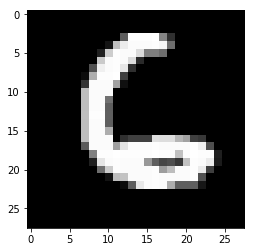

In [6]:
plt.imshow(images[0].reshape(28,28),cmap='gray')

In [7]:
class Discriminator(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(Discriminator,self).__init__()
        
        self.fc1=nn.Linear(input_dim, hidden_dim*4)
        self.fc2=nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3=nn.Linear(hidden_dim*2,hidden_dim)
        
        self.fc4=nn.Linear(hidden_dim, output_dim)
        
        self.lrelu=nn.LeakyReLU(0.2)
        
        self.dropout=nn.Dropout(0.3)
    
    def forward(self,x):
        x=x.view(-1,28*28)
        
        x=self.dropout(self.lrelu(self.fc1(x)))
        
        x=self.dropout(self.lrelu(self.fc2(x)))
        
        x=self.dropout(self.lrelu(self.fc3(x)))
        
        out=self.fc4(x)
        
        return out

In [8]:
class Generator(nn.Module):
    
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(Generator,self).__init__()
        
        self.fc1=nn.Linear(input_dim, hidden_dim)
        self.fc2=nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3=nn.Linear(hidden_dim*2,hidden_dim*4)
        
        self.fc4=nn.Linear(hidden_dim*4, output_dim)
        
        self.lrelu=nn.LeakyReLU(0.2)
        self.tanh=nn.Tanh()
        
        self.dropout=nn.Dropout(0.3)
    
    def forward(self,x):
        
        x=self.dropout(self.lrelu(self.fc1(x)))
        
        x=self.dropout(self.lrelu(self.fc2(x)))
        
        x=self.dropout(self.lrelu(self.fc3(x)))
        
        out=self.tanh(self.fc4(x))
        
        return out
        
        

In [9]:
#discriminator
input_dim=784
hidden_dim=32
output_dim=1
D=Discriminator(input_dim, hidden_dim, output_dim)

#generator
z_size=100
hidden_dim=32
output_dim=784
G=Generator(z_size, hidden_dim, output_dim)

In [26]:
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.3)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3)
)


In [21]:
D.cuda()
G.cuda()

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3)
)

In [25]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    labels=labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels=labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [32]:
d_optimizer=optim.Adam(D.parameters(), lr=0.002)
g_optimizer=optim.Adam(G.parameters(), lr=0.002)

In [ ]:
epochs=100
z_size=100
for e in range(epochs):
    running_d_loss=0
    running_g_loss=0
    for batch_i,(real_images , _) in enumerate(trainloader):
        batch_size=real_images.size(0)
        real_images=real_images*2 - 1 #for making pixels between 0 to 1 to -1 to 1
        real_images=real_images.cuda()
        
        
        #Training Discriminator
        #Real images
        d_optimizer.zero_grad()
        
        D_real = D(real_images)
        
        d_real_loss=real_loss(D_real)
        
        #Fake images
        
        z=np.random.uniform(-1,1,size=(batch_size,z_size))   #batch_size , z_size
        z=torch.from_numpy(z).float()
        z=z.cuda()
        
        fake_images=G(z)
        D_fake = D(fake_images)
        
        d_fake_loss=fake_loss(D_fake)
        
        d_loss=d_real_loss + d_fake_loss
        
        d_loss.backward()
        d_optimizer.step()
        
        #Training Generator
        g_optimizer.zero_grad()
        
        z=np.random.uniform(-1,1,size=(64,100))   #batch_size , z_size
        z=torch.from_numpy(z).float()
        z=z.cuda()
        fake_images=G(z)
        
        D_fake = D(fake_images)
        g_loss=real_loss(D_fake)
        
        g_loss.backward()
        g_optimizer.step()
        
        running_d_loss+=d_loss.item()
        running_g_loss+=g_loss.item()
        
    else:
        print('Epoch: {}/{} | g_loss : {} | d_loss : {} '.format(e+1,epochs,running_g_loss/len(trainloader),
                                                                 running_d_loss/len(trainloader)))
    
        

Epoch: 1/100 | g_loss : 1.0178825089545138 | d_loss : 1.246607458921892 
Epoch: 2/100 | g_loss : 1.0058097809489601 | d_loss : 1.242680179793189 
Epoch: 3/100 | g_loss : 1.0102810184838675 | d_loss : 1.2398818573082433 
Epoch: 4/100 | g_loss : 0.9713817581947424 | d_loss : 1.2488599697918272 
Epoch: 5/100 | g_loss : 1.0415977417533078 | d_loss : 1.2407559391532117 
Epoch: 6/100 | g_loss : 1.0265460571627627 | d_loss : 1.2307800198795953 
Epoch: 7/100 | g_loss : 0.9700987993527069 | d_loss : 1.2458727944380186 
Epoch: 8/100 | g_loss : 0.9687487693991996 | d_loss : 1.2524235970430029 
